<a href="https://colab.research.google.com/github/aminKMT/RNN-LastMile/blob/main/LSTM_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Using simple LSTM  and LSTM+MLP for Last mile problem:

## Simple LSTM
* issue: you shoudl concider N-1 stop to not have data leakage. To resolve we used MLP+ LSTM  



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Simulated delivery sequence: 3 deliveries, 3 stops each
X_raw = torch.tensor([
    [[0.0, 0.2, 0.5], [1.0, 0.3, 0.4], [2.0, 0.4, 0.6]],
    [[0.0, 0.1, 0.2], [2.0, 0.2, 0.1], [4.0, 0.3, 0.3]],
    [[0.0, 0.3, 0.3], [1.0, 0.4, 0.5], [3.0, 0.5, 0.6]]
], dtype=torch.float32)

# Delivery time (in days) at the final stop
y_raw = torch.tensor([2.0, 4.0, 3.0], dtype=torch.float32)

# Dataset and DataLoader
dataset = TensorDataset(X_raw, y_raw)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# LSTM model definition
class ETA_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1]).squeeze(1)

# Model, loss, optimizer
model = ETA_LSTM(input_dim=3, hidden_dim=32)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(100):
    model.train()
    for xb, yb in loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Predict on unseen sequence
X_unseen = torch.tensor([[[0.0, 0.15, 0.25], [1.5, 0.25, 0.35], [3.5, 0.35, 0.45]]], dtype=torch.float32)

model.eval()
with torch.no_grad():
    pred_eta = model(X_unseen).item()

print(f"📦 Predicted delivery time (ETA) at final stop: {pred_eta:.2f} days")


📦 Predicted delivery time (ETA) at final stop: 3.51 days


# Ussing the combinaion of LSTM and MLP to resulve data leakage of the last stop(N) delivery time

---



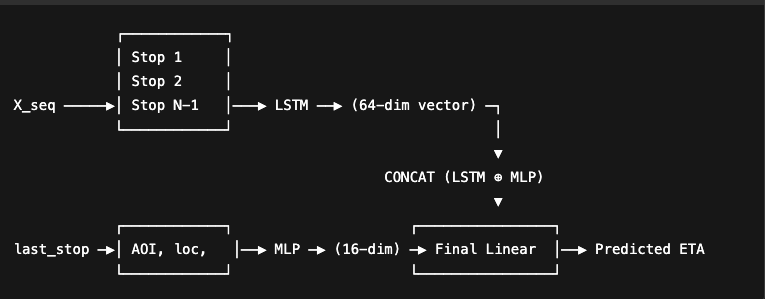

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 1. Simulated dataset
X_raw = torch.tensor([
    [[0.0, 0.2, 0.5], [1.0, 0.3, 0.4], [2.0, 0.4, 0.6]],
    [[0.0, 0.1, 0.2], [2.0, 0.2, 0.1], [4.0, 0.3, 0.3]],
    [[0.0, 0.3, 0.3], [1.0, 0.4, 0.5], [3.0, 0.5, 0.6]]
], dtype=torch.float32)  # Shape: [3, 3, 3]

y_raw = torch.tensor([2.0, 4.0, 3.0], dtype=torch.float32)

# 2. Split input into sequence and last stop
X_seq = X_raw[:, :-1, :]   # first 2 stops (shape: [3, 2, 3])
X_last = X_raw[:, -1, :]   # last stop only (shape: [3, 3])

# 3. Dataset and DataLoader
dataset = TensorDataset(X_seq, X_last, y_raw)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# 4. Define the combined model
class ETA_LSTM_with_LastStop(nn.Module):
    def __init__(self, input_dim, laststop_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.last_stop_head = nn.Sequential(
            nn.Linear(laststop_dim, 4),
            nn.ReLU()
        )
        self.combined_fc = nn.Sequential(
            nn.Linear(hidden_dim + 4, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x_seq, x_last):
        _, (hn, _) = self.lstm(x_seq)
        lstm_out = hn[-1]
        last_out = self.last_stop_head(x_last)
        combined = torch.cat([lstm_out, last_out], dim=1)
        return self.combined_fc(combined).squeeze(1)

# 5. Initialize model
model = ETA_LSTM_with_LastStop(input_dim=3, laststop_dim=3, hidden_dim=6)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# 6. Train the model
for epoch in range(100):
    model.train()
    for x_seq_batch, x_last_batch, y_batch in loader:
        pred = model(x_seq_batch, x_last_batch)
        loss = loss_fn(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 7. Predict for unseen delivery
X_seq_unseen = torch.tensor([[[0.0, 0.25, 0.4], [1.2, 0.35, 0.5]]], dtype=torch.float32)  # shape [1, 2, 3]
X_last_unseen = torch.tensor([[2.5, 0.45, 0.55]], dtype=torch.float32)  # shape [1, 3]

model.eval()
with torch.no_grad():
    pred_eta = model(X_seq_unseen, X_last_unseen).item()

print(f"📦 Predicted ETA for unseen delivery: {pred_eta:.2f} days")


📦 Predicted ETA for unseen delivery: 2.55 days
